In [1]:
fname = "../hanglog/mild_swinging/hdata-2021-01-05_19-24-22.log"
fname = "../hanglog/mild_swinging/hdata-2021-01-11_13-37-07.log"

import os, sys
sys.path.append("..")
import hacktrack.loaders
import pandas, numpy, math
import scipy.optimize
from matplotlib import pyplot as plt
from hacktrack import loaders, utils
from hacktrack.utils import qvec, qmult, InterpT, curvefitdifferentiate, intercurvefitdifferentiate, angularspeedsquaredfromvector
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fd = loaders.FlyDat(fname)
fd.LoadC("ZY")

# assign timevalues in seconds to these tables
fd.pY["t"] = (fd.pY.index - fd.t0)/pandas.Timedelta(seconds=1)
fd.pZ["t"] = (fd.pZ.index - fd.t0)/pandas.Timedelta(seconds=1)

# filter the spikes
Z0 = fd.pY[~fd.pY.bad]
Z1 = fd.pZ[~fd.pZ.bad]


t0 = fd.t0 + pandas.Timedelta(seconds=2)
t1 = t0 + pandas.Timedelta(seconds=58)
A = Z1[t0:t1]


Extracting knowndate from filename: 2021-01-11
E:1, Y:3987, Z:4089, aA:617, aZ:617, aF:607
linAdifftime 2297483.145320197 count 609
Made for Q 0 last index 0
Made for V 0 last index 0
Loading aQV as no pQV records
Made for aQ 0 last index 0
Made for aV 0 last index 0
Missing GPS data, so setting t0 to 2021-01-11 13:34:51.878145
Made for Z 4089 last index 4089
Warning, using guessed (not GPS) timing corrected value on Z 4089
pCattrname pZ
Made for Y 3987 last index 3987
Warning, using guessed (not GPS) timing corrected value on Y 3987
pCattrname pY


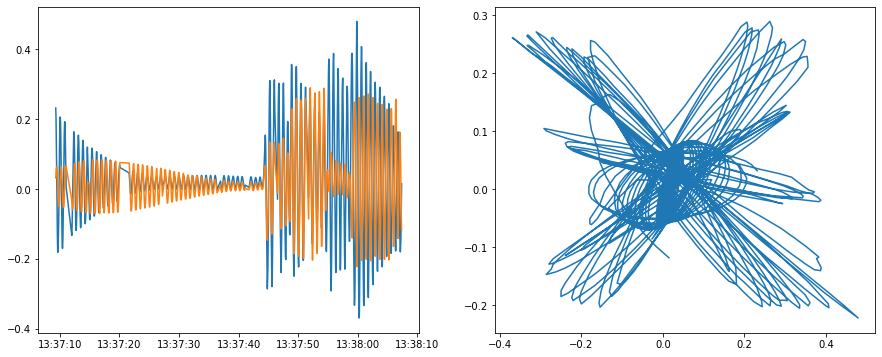

In [2]:
t0 = fd.t0 + pandas.Timedelta(seconds=2)
t1 = t0 + pandas.Timedelta(seconds=58)
A = Z1[t0:t1]


px, py, pz = qvec((A.q0, -A.q1, -A.q2, -A.q3), (0,0,1))
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(px)
plt.plot(py)
plt.subplot(122)
plt.plot(px, py)


In [14]:
# pic a different axis from (0,0,1)
# check the gyros resolve in that direction

ws = 0.18
as2 = angularspeedsquaredfromvector(px, py, pz, ws)

unexplained mismatch by factor of two between the square values


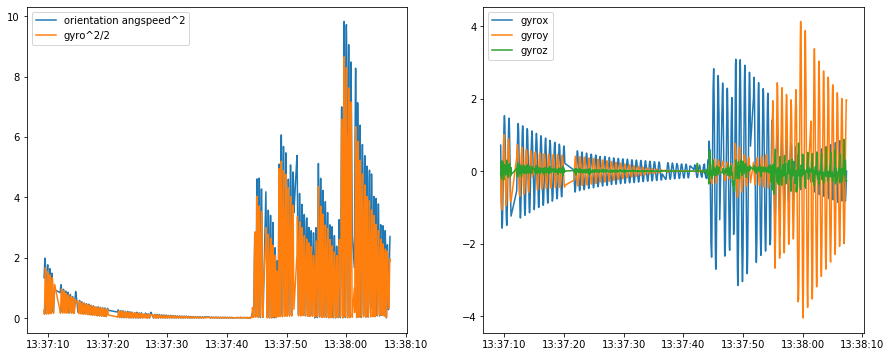

In [15]:
gyrom = A.mx**2 + A.my**2   # radians per second yaw each axis
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(as2, label="orientation angspeed^2")
plt.plot(gyrom*0.5, label="gyro^2/2")
plt.legend()
plt.subplot(122)
plt.plot(A.mx, label="gyrox")
plt.plot(A.my, label="gyroy")
plt.plot(A.mz, label="gyroz")
plt.legend()
print("unexplained mismatch by factor of two between the square values")

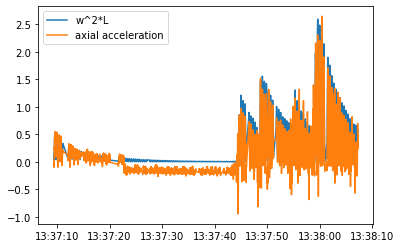

In [17]:
plt.plot((A.mx**2 + A.my**2)*0.15, label="w^2*L")
plt.plot(-A.az, label="axial acceleration")
plt.legend()


In [55]:
B = Z0[t0-pandas.Timedelta(seconds=1):t1+pandas.Timedelta(seconds=1)]   # top accelerometer
Bacc = (B.ax+B.gx, B.ay+B.gy, B.az+B.gz)
Bax, Bay, Baz = qvec((B.q0, -B.q1, -B.q2, -B.q3), Bacc)

In [3]:
# pendulum accelerometer
A = Z1[t0:t1]

# Unit axis of pendulum in real world space
px, py, pz = qvec((A.q0, -A.q1, -A.q2, -A.q3), (0,0,1))

# axial centrifugal acceleration derived from the gyros of the pendulum
centrifugal = (A.mx**2 + A.my**2)*0.15

# top accelerometer
B = Z0[t0-pandas.Timedelta(seconds=1):t1+pandas.Timedelta(seconds=1)]

# combined acceleration in its own frame
Bacc = (B.ax+B.gx, B.ay+B.gy, B.az+B.gz)

# acceleration in real world frame
Bax, Bay, Baz = qvec((B.q0, -B.q1, -B.q2, -B.q3), Bacc)

# interpolated and smoothed to fit the timeseries of the pendulum
Baxp = intercurvefitdifferentiate(px.index, Bax, 0.18, 2)[0]
Bayp = intercurvefitdifferentiate(px.index, Bay, 0.18, 2)[0]
Bazp = intercurvefitdifferentiate(px.index, Baz, 0.18, 2)[0]

# acceleration of top of pendulum resolved along the axis of the pendulum
axialacc = Baxp*px + Bayp*py + Bazp*pz


# Claim: centrifugal-axialacc == total acceleration on the Az axial component of acceleration at enf of pendulum
plt.plot(-A.az-A.gz, label="axial acceleration")
plt.plot(centrifugal-axialacc)
print("These two plots are equal")


<IPython.core.display.Javascript object>


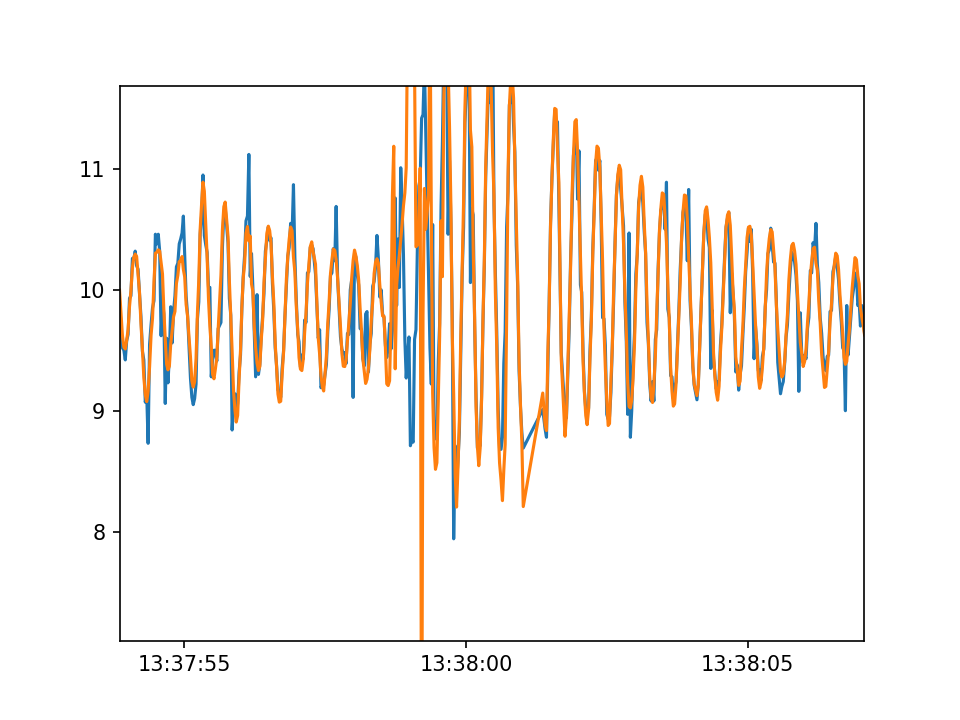

In [4]:
%matplotlib notebook
plt.plot(-A.az-A.gz, label="axial acceleration")
plt.plot(centrifugal-axialacc)


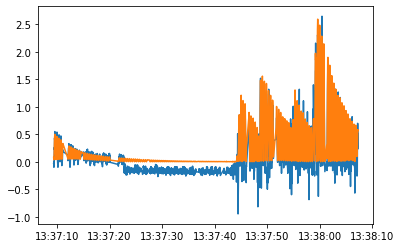

In [67]:
%matplotlib inline
centrifugal = (A.mx**2 + A.my**2)*0.15
plt.plot(-A.az, label="axial acceleration")
plt.plot(centrifugal)
#plt.plot(axialacc)


<IPython.core.display.Javascript object>


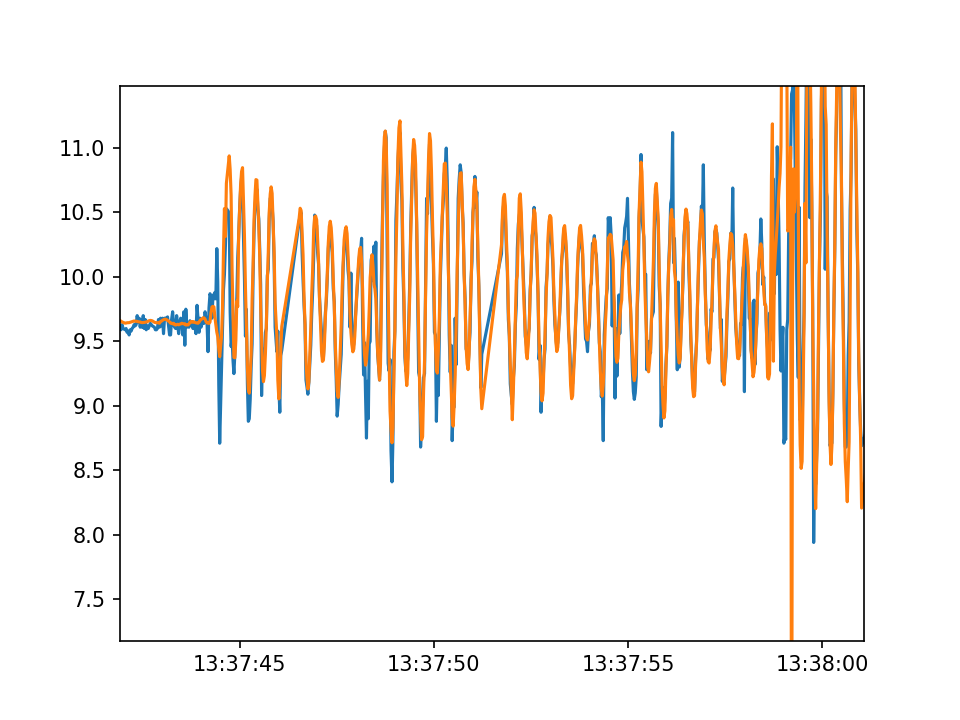

In [5]:
(2*3.14*math.sqrt(1.3/9.8))

2.2872744675259065

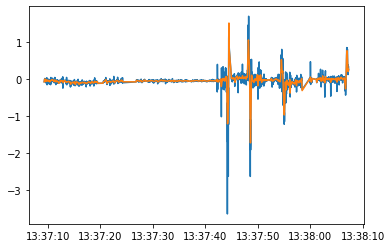

In [31]:
plt.plot(Bay)
plt.plot(Bayp)


proof that the angularspeedsquaredfromvector function correctly measures 1rad/sec


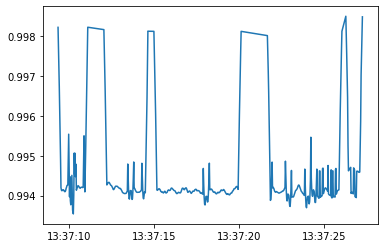

In [9]:
sec1 = pandas.Timedelta(seconds=1)
pt = pandas.Series((px.index-px.index[0])/sec1, px.index)[:t0 + pandas.Timedelta(seconds=18)]
px = numpy.sin(pt)
py = pt*0
pz = numpy.cos(pt)
as2 = angularspeedsquaredfromvector(px, py, pz, 0.18)
plt.plot(as2)
print("proof that the angularspeedsquaredfromvector function correctly measures 1rad/sec")